# Assignment 5A
* @Shachidev 
` Date: 11-02-2025`

 * Details of the system
     - N = 216
     - rho = 0.8442
     - mass = 1.0
     - $\sigma$ = 1.0
     - $\epsilon$ = 1.0
     - r$_\text{cut}$ = 2.5$\sigma$
     - dt = 0.001
     - kBT = 1.0

In [84]:
# Full MD code

import time
import sys
import numpy as np
import matplotlib.pyplot as plt


### Parameters of the system

In [85]:
N=216     # Total no. of particles.(cube root must be integer)
m=1.0
sig=1.0
roh=0.8442
epsilon = 1.0
rc = 2.5    # cutoff lenth
box_length = 6.348475790538236 # for roh = 0.8442
k_B  = 1.0
T = 1.0   # Initial Temperature
T0 = 0.1   # Desired Temperature 

#Time , timestep, count, maxcount are written below(in main program cell)

# Functions

## Velocity initialize

In [86]:
import numpy as np
N = 216   # Number of particles
def velocity_initialize(N):
    """Initialize velocities of N particles from a normal distribution, 
    remove net momentum, and normalize."""
    # T is given temprature
    mean = 0
    std_dev = 0.1
    bins = int(np.sqrt(N))

    # Generate velocities and remove net momentum
    velocities = np.random.normal(mean, std_dev, (N, 3))
    velocities -= velocities.mean(axis=0)

    # Normalize to match desired temperature
    temperature = 0.5 * np.sum(velocities**2)
    velocities *= np.sqrt(T/temperature)

    temperature = 0.5 * np.sum(velocities**2)
    print('Initial Temperature = ', temperature)
    
    return velocities[:, 0], velocities[:, 1], velocities[:, 2]
    

## periodic boundary condition and minimum image convention

In [87]:
import math
def PBC(coord,box_length):
    """
    PBC is applied in this function.
    coord: 2D array of size (particle no. , 3)
    box_lenth: lenth of one side of cubic box
    """

    # 
    for i in range(N): 
        for j in range(3):
            if (coord[i, j] > box_length):
                coord[i, j] -= box_length* math.floor(coord[i, j]/box_length)
            elif (coord[i, j] < 0.0):
                coord[i, j] -= box_length* math.floor(coord[i, j]/box_length)
    return coord

def min_img_conv(coordinate1, coordinate2, box_length):
    displacement = coordinate2 - coordinate1
    displacement -= np.round(displacement / box_length) * box_length
    return displacement



## Force calculation

In [88]:
def forces(coordinates):
    """
    This function is for calculate total force on each particles and total potential energy.
    Input: coordinates(particle no. , 3)
    Output: Force(Particle no.) and Total pot
    """
    #print('r cutoff  =  ', rc)
    rc2 = rc**2
    npart=N
    F=np.zeros([npart,3])
    total_pot = 0.0
    r2c = 1/rc2
    r6c = r2c**3
    pot_cut = 4.0*r6c*(r6c-1)
    
    with open("force.txt", "w") as f:
        f.write(f"fx \t \t fy \t \t fz \n")
    
    for i in range(npart-1):
        for j in range(i+1,npart):
            dx,dy,dz = min_img_conv(coordinates[j,:], coordinates[i,:], box_length)
            r2 = dx**2+dy**2+dz**2
            if (r2 < rc2) :
                r2i = 1/r2
                r6i = r2i**3
                ff = 48.0*r2i*r6i*(r6i - 0.5)
                F[i,0] = F[i,0] + ff*dx
                F[j,0] = F[j,0] - ff*dx
                F[i,1] = F[i,1] + ff*dy
                F[j,1] = F[j,1] - ff*dy
                F[i,2] = F[i,2] + ff*dz
                F[j,2] = F[j,2] - ff*dz
                total_pot = total_pot + 4.0*r6i*(r6i-1)- pot_cut
    
    for i in range(npart):
        with open("force.txt", "a") as f:
            f.write(f"{F[i,0]:.8f}\t{F[i,1]:.8f}\t{F[i,2]:.8f} \n")
    
    return F, total_pot
            

## Integratrion

In [89]:

def integrate(force, coords,velos,totpot,sig, box_length, N):
    # Velocity Verlet algorthm
    velos += force * (dt / 2.0)
    coords += velos * dt
    # PBC check
    coords = PBC(coords,box_length)
    # Force calculation
    force, total_pot = forces(coords)

    velos += force * (dt / 2.0)

    vi2tot = np.sum(velos**2)
    #Thermostat                             <------------------------------------------------------------
    alpha = np.sqrt((3 * N * k_B * T0) / (m * vi2tot)) 
    velos *= alpha              # Element-wise multiplication

    
    threshold = sig/10
    # Initialize overlap detection flag
    overlap_detected = False
    for i in range(N-1):
        for j in range(i+1, N):
            dx,dy,dz = min_img_conv(coords[i,:], coords[j,:], box_length)
            dr = np.sqrt(dx**2 + dy**2 +dz**2)
            if dr < threshold:
                print(f"Warning: Particles {i} and {j} overlap! at time = {t:.4f} count = {count}")
                print("Overlapping detected, stopping the simulation.")
                overlap_detected = True
                break
        if overlap_detected:
            sys.exit()
            break

    # Remove CM velocity
    velos -= velos.mean(axis=0)
    vi2tot = np.sum(velos**2, axis=0)
    kin_tot = 0.5*sum(vi2tot)/N
    poten_tot = total_pot/N
    etot = (poten_tot + kin_tot)
    temp = sum(vi2tot)/(3*N)
    
    return coords,force,kin_tot,poten_tot, etot, temp, velos




## Sampling

In [90]:
def write_gro(file_pointer, coordinates, velocities, box_dims, residue_name, atom_name):
    r"""
    Appends a frame to a .gro file.

    Parameters:
    - file_pointer: Open file object in append mode.
    - coordinates: array of (x, y, z) tuples for atom positions in nm.
    - velocities:array of (vx, vy, vz) tuples for atom velocities in nm/ps.
    - box_dims: array of (x, y, z) for box dimensions in nm.
    - residue_name: Residue name (default: 'Ar').
    - atom_name: Atom name (default: 'Ar').
    """
    num_atoms = len(coordinates)

    # Write frame header and number of atoms
    file_pointer.write("Appended Frame\n")
    file_pointer.write(f"{num_atoms:5d}\n")

    # Write atom information
    for i, ((x, y, z), (vx, vy, vz)) in enumerate(zip(coordinates, velocities), start=1):
        residue_number = 1  # Default residue number
        atom_number = i
        file_pointer.write(f"{residue_number:5d}{residue_name:<5}{atom_name:>5}{atom_number:5d}{x:8.3f}{y:8.3f}{z:8.3f}{vx:8.4f}{vy:8.4f}{vz:8.4f}\n")

    # Write box dimensions
    file_pointer.write(f"{box_dims[0]:10.5f}{box_dims[1]:10.5f}{box_dims[2]:10.5f}\n")
    

# Main Program

In [91]:
cpu_start = time.process_time()

# position initiaalize
d = box_length/6.0
box_dims=(box_length, box_length, box_length)
coordds = np.array([[i, j, k] for i in range(6) for j in range(6) for k in range(6)], dtype=float) * d
coordds += d / 2


x, y, z = coordds.T
print('Position initialized!!')

# call the function for velocity init
vx,vy,vz=velocity_initialize(N)
print('Velocity initialized!!')

# pack into 2d array
V=np.column_stack((vx, vy, vz))
X=np.column_stack((x, y, z))
# Initial configuration store
with open("init.gro", "w") as f:
        f.write(f"216 particles in a box intrect with L-J pot \n")
        f.write('216\n')
for i in range(N):
    with open("init.gro", "a") as f:
        f.write(f"1 \t Ar \t Ar \t {i:4d} \t {X[i,0]:.8f}\t{X[i,1]:.8f}\t{X[i,2]:.8f} \n")
with open("init.gro", "a") as f:
        f.write(f" {box_length:.8f}\t{box_length:.8f}\t{box_length:.8f} \n")



#Array for store and ploting the energy and temp
tarray = []
Temparray = []
#Main loop of the simulation                  <-------------------------------------------
Etot = 0.0
Temp = 0.0
with open("energies_nvt.txt", "w") as file:
    file.write(f" Time \t \t step \t \t Kin_energy \t\t Pot_energy \t\t Tot_energy \n")
    
# Parameters for main loop                  <-------------------------------------------
t = 0.0
dt = 0.001
coords_old = X - V * dt
count=0
max_count = 500
F, total_pot = forces(X)
while (count < max_count):
    # # Temp append for ploting 
    tarray.append(t)
    Temparray.append(Temp)
    # force input forct out PBCc all inside
    X,F,Total_kin, Total_pot, Etot, Temp,V = integrate(F, X, V, total_pot,sig, box_length, N)
    
    if (np.mod(count,10) == 0):
        with open("energies_nvt.txt", "a") as file:
            file.write(f"{t:.8f} \t {count:6d} \t {Total_kin:.8e} \t {Total_pot:.8e} \t {Etot:.8e}\n")
        with open("nvt.gro", "a") as f:
            write_gro(f, X, V, box_dims, "Ar", "Ar")
    t = t + dt
    count=count+1
print('Desired Temprature = ',T0)
print('Final Temprature = ',Temp)
print('DONE!!!  Value are stored in the file')
cpu_end = time.process_time()
print("CPU Time(s) = ", cpu_end - cpu_start)



Position initialized!!
Initial Temperature =  1.0000000000000002
Velocity initialized!!
Desired Temprature =  0.1
Final Temprature =  0.10000000000000002
DONE!!!  Value are stored in the file
CPU Time(s) =  275.84375


In [92]:
Temparray = np.array(Temparray)
print(Temparray.shape)
print(Temparray[0:10])

(500,)
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


## Energy vs time Ploting 

Data shape: (1000, 5)


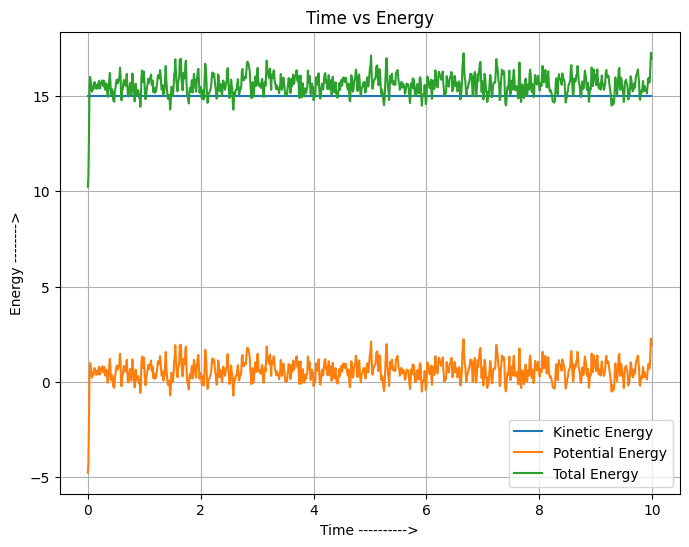

In [95]:
# Load data from file and ploting of energies
data = np.loadtxt("energies_nvt.txt", skiprows=1,ndmin=2)
print("Data shape:", data.shape)
# Extract columns
time = data[:, 0]         
kinetic_energy = data[:, 2]    
potential_energy = data[:, 3]  
total_energy = data[:, 4]      

# Plot the data
plt.figure(figsize=(8, 6))

plt.plot(time, kinetic_energy, label="Kinetic Energy", linestyle="-")
plt.plot(time, potential_energy, label="Potential Energy", linestyle="-")
plt.plot(time, total_energy, label="Total Energy", linestyle="-",)

# Labels and Title
plt.xlabel("Time ---------->")
plt.ylabel("Energy -------->")
plt.title("Time vs Energy")
plt.legend()
plt.grid(True)

plt.savefig("nvt.pdf", format="pdf", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()


# Temperature plot with time

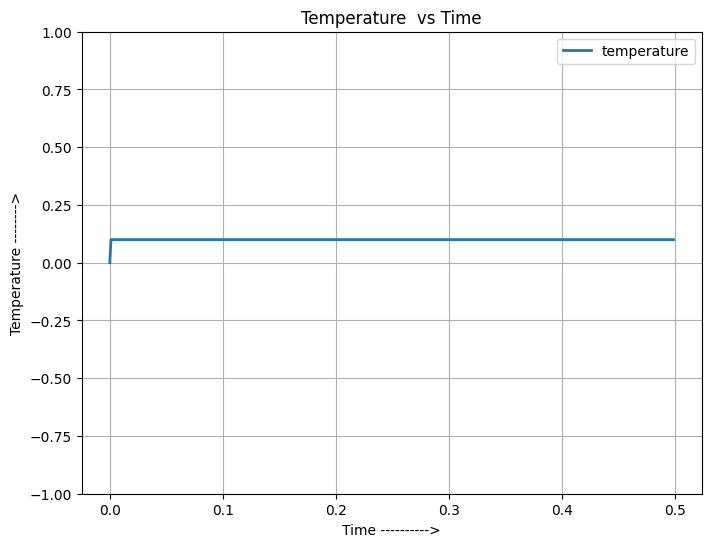

In [94]:
# Plot the data
plt.figure(figsize=(8, 6))

plt.plot(tarray, Temparray, linewidth=2, label="temperature", linestyle="-")

# Labels and Title
plt.xlabel("Time ---------->")
plt.ylabel("Temperature -------->")
plt.ylim(-1,1)
plt.title("Temperature  vs Time")
plt.legend()
plt.grid(True)

plt.savefig("Temperature.pdf", format="pdf", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()